In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from local.Net_learn_means_AcFB import AcFB, Relevance_AdaptiveWeights_acousticFB1, Relevance_BandWeights_acousticFB
from local.models import LSTMClassifier
from local.utils import *
import argparse, configparser
import scipy.io as sio

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

/home/share/anaconda3/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
args={

    'num_freq_bin': 64,
    'model_config':'conf/model_config',
    'use_relWt':True,
    'relevance_type':'adaptiveWt',
    'relContext':51,
    'mean_var_norm': True,
    'use_mixup':False,
    'acfb_preTrained':True,
    'use_skipConn':False,
    'deltas':True,
    'feat_config':'conf/feature.conf',
    "fs":44100
}

audiocatgory='breathing'
outerid=0
#resdir='breathing/feats_results_BLSTM_segment_PRETRAIN_FB_CAMBRIDGE_SR44_WD0-0_BSZ8_finetune_sigFac2_acfb0.001_cls0.0001_lambda0.001_tanh_initrand1_sch/'
resdir='breathing/feats_results_BLSTM_segment_PRETRAIN_FB_CAMBRIDGE_SR44_WD0-0_BSZ8_finetune_sigFac2_relHiddenTanh_acfb0.001_cls0.0001_lambda0.001_tanh_initrand1_sch'
resdir=resdir+"/"+str(outerid)
chkdir=resdir+'/ClsCheckpoint'
model_path=chkdir+'/best_frame_auc_model.pth'
max_count=100

In [3]:
import glob 

figdir=resdir+"/figs/SPEC-MASKS/"
all_files=glob.glob(figdir+"Mask-*.mat")
print(len(all_files), all_files[:1])

200 ['breathing/feats_results_BLSTM_segment_PRETRAIN_FB_CAMBRIDGE_SR44_WD0-0_BSZ8_finetune_sigFac2_relHiddenTanh_acfb0.001_cls0.0001_lambda0.001_tanh_initrand1_sch/0/figs/SPEC-MASKS/Mask-IOHZIUVB:p.mat']


In [4]:
pos_files = []
neg_files = []
added_files=  []

for f in all_files:
    data=sio.loadmat(f)['data']
    cat = f.split(":")[-1].split(".")[0]
    fid = f.split(":")[0].split("-")[-1]

    if fid in added_files: continue

    if cat == 'p':
        pos_files.append(data)
    elif cat == 'n':
        neg_files.append(data)
    else:
        raise ValueError("Unknown Category!!")


    added_files.append(fid)

print("num pos files: {}, neg files: {}".format(len(pos_files), len(neg_files)))

num pos files: 100, neg files: 100


In [5]:
pos_combined = np.concatenate(pos_files,axis=1)
neg_combined = np.concatenate(neg_files, axis=1)
print(pos_combined.shape, neg_combined.shape)

(64, 84937) (64, 112870)


In [6]:
n_blocks=10

bw=args['num_freq_bin']//n_blocks
start=0

grouped_wts = []
band_ids=[]
#neg_band_ids=[]
categ_ids=[]

while start < args['num_freq_bin']:
   
    end=min([start+bw,args['num_freq_bin']])
    pos_band_weights=pos_combined[start:end,:]
    neg_band_weights=neg_combined[start:end,:]

    pos_band_weights=pos_band_weights.reshape(-1)
    n_pos=len(pos_band_weights)
    neg_band_weights=neg_band_weights.reshape(-1)
    n_neg=len(neg_band_weights)

    grouped_wts.extend(pos_band_weights)
    bid = (start + end)//2
    band_ids.extend(["{}-{}".format(start+1,end)]*n_pos)
    categ_ids.extend(["pos"]*n_pos)

    grouped_wts.extend(neg_band_weights)
    band_ids.extend(["{}-{}".format(start+1, end)]*n_neg)
    categ_ids.extend(["neg"]*n_neg)
    start=end

print(len(grouped_wts), len(band_ids), len(categ_ids))

    

12659648 12659648 12659648


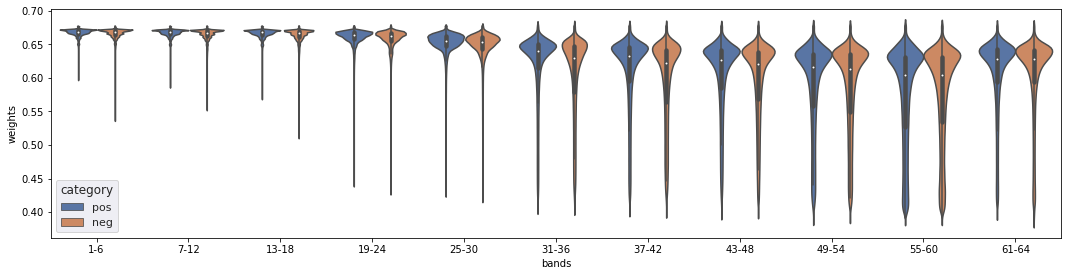

In [8]:
import seaborn as sns
from matplotlib import rcParams

dict={"weights":grouped_wts,"bands":band_ids, "category":categ_ids}
data=pd.DataFrame(dict)

fig, ax = plt.subplots(1, figsize=(15,4))
sns.set(rc={'figure.figsize':(15,5)})
#rcParams['figure.figsize'] = 5, 8
sns.violinplot(ax=ax, x="bands",y="weights",hue="category", data=data, showfliers=False) # split=True, ) # palette='BuGn')
plt.tight_layout()
outf=resdir+"/figs/clsRelWt/violinPlot_wt_dist.png"
#plt.savefig(outf)
outpdf=outf[:-4]+".pdf"
plt.savefig(outpdf)
plt.show()


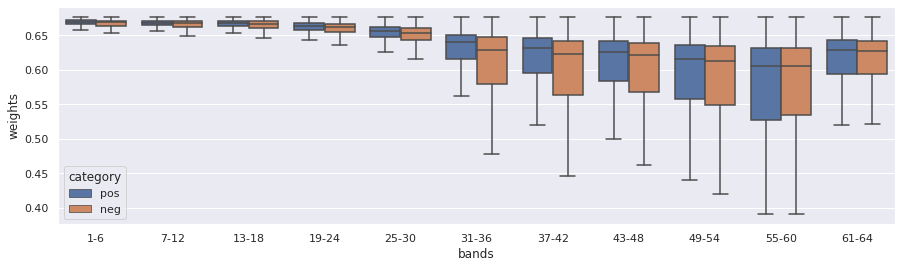

In [48]:
fig = plt.figure(figsize=(15,4))
#sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="bands",y="weights",hue="category", data=data, showfliers=False) # split=True, ) # palette='BuGn')
#plt.tight_layout()
outf=resdir+"/figs/clsRelWt/boxPlot_wt_dist.png"
plt.savefig(outf)
outpdf=outf[:-4]+".pdf"
plt.savefig(outpdf)
plt.show()